# MaterialPointSolver.jl Showcase 01

Author: Zenan Huo <br>
Date: 25-Aug-2024 <br>

---

This case is the 2D soil collapse test in MPM. Here we use drucker-prager to model the soil, uGIMP under MUSL update scheme is chose. You can also modify these preference in variable `args`, e.g., in `args` instantiation: 
```julia
...
device = :CUDA,
...
```
you can change to `:CPU` to use CPU on your computer. To enable multi-thread mode, you have to check the threads launched by Julia:

```julia
Threads.nthreads()
```
This will show how many threads you are accessing now.

### Import Packages

In [1]:
using MaterialPointSolver
using HDF5
using CairoMakie
using DelimitedFiles
using CUDA


⚠ please try to warm up before simulating:

help?> warmup


┌ Info: A high-performance MPM solver in Julia 🚀[0
│ version    : v0.2.0
└ affiliation: Risk Group, UNIL-ISTE


In [2]:
warmup(Val(:CUDA)) # optional

[ Info: code warm-up, wait a moment 🔥


init grid space: <br>
0.00250:   12800 pts <br>
0.00181:   24200 pts <br>
0.00125:   51200 pts <br>
0.00050:  320000 pts <br>

In [3]:
rtsdir     = joinpath(@__DIR__, "outputs")
assetsdir  = MaterialPointSolver.assets_dir
figregular = MaterialPointSolver.tnr
figbold    = MaterialPointSolver.tnrb

init_grid_space_x = 0.0025
init_grid_space_y = 0.0025
init_grid_range_x = [-0.1, 0.82]
init_grid_range_y = [-0.1, 0.12]
init_mp_in_space  = 2
init_project_name = "2d_collapse"
init_project_path = joinpath(rtsdir, init_project_name)
init_constitutive = :druckerprager
init_vtk_step     = 1
init_gravity      = -9.8
init_ζs           = 0
init_ρs           = 2650
init_ν            = 0.3
init_Ks           = 7e5
init_E            = init_Ks * (3 * (1 - 2 * init_ν))
init_G            = init_E  / (2 * (1 +     init_ν))
init_T            = 1
init_Te           = 0
init_ΔT           = 0.5 * init_grid_space_x / sqrt(init_E / init_ρs)
init_step         = (t = floor(init_T / init_ΔT / 100); t<10 ? 1 : t)
init_σt           = 0
init_ϕ            = deg2rad(19.8)
init_c            = 0
init_ψ            = 0
init_NIC          = 16
init_basis        = :uGIMP
init_phase        = 1
init_scheme       = :MUSL
iInt              = Int64
iFloat            = Float64;

### Parameters Setup

In [4]:
args = Args2D{iInt, iFloat}(
    Ttol         = init_T,
    Te           = init_Te,
    ΔT           = init_ΔT,
    time_step    = :fixed,
    FLIP         = 1.0,
    PIC          = 0.0,
    ζs           = init_ζs,
    project_name = init_project_name,
    project_path = init_project_path,
    constitutive = init_constitutive,
    animation    = false,
    hdf5         = false,
    hdf5_step    = init_step,
    MVL          = false,
    device       = :CUDA,
    coupling     = :OS,
    scheme       = init_scheme,
    basis        = init_basis
)

Args2D{Int64, Float64}
──────────────────────
project name    : 2d_collapse
project path    : C:\Users\zenan\Workbench\outputs\2d_collapse
precision       : FP64
constitutive    : druckerprager
basis method    : uGIMP
mitigate vollock: false
coupling scheme : OS


### Background Grid Setup

In [5]:
grid = Grid2D{iInt, iFloat}(
    NIC      = init_NIC,
    phase    = init_phase,
    range_x1 = init_grid_range_x[1],
    range_x2 = init_grid_range_x[2],
    range_y1 = init_grid_range_y[1],
    range_y2 = init_grid_range_y[2],
    space_x  = init_grid_space_x,
    space_y  = init_grid_space_y
)

Grid2D{Int64, Float64}
──────────────────────
node: 32841
cell: 32384


### Material Points Setup

In [6]:
space_x = grid.space_x / init_mp_in_space
space_y = grid.space_y / init_mp_in_space
x_tmp, y_tmp = meshbuilder(0 : space_x / 2 : 0.2, 0 : space_y / 2 : 0.1)
mp_num = length(x_tmp)
mp_ρs  = ones(mp_num).*init_ρs
mp     = Particle2D{iInt, iFloat}(space_x=space_x, space_y=space_y, pos=[x_tmp y_tmp],
    ρs=mp_ρs, NIC=init_NIC, phase=init_phase)

Particle2D{Int64, Float64}
──────────────────────────
particle: 51681


### Particle Property Setup

In [7]:
mp_layer = ones(mp_num)
mp_ν     = [init_ν]
mp_E     = [init_E]
mp_G     = [init_G]
mp_σt    = [init_σt]
mp_ϕ     = [init_ϕ]
mp_c     = [init_c]
mp_ψ     = [init_ψ]
mp_Ks    = [init_Ks]
pts_attr = ParticleProperty{iInt, iFloat}(layer=mp_layer, ν=mp_ν, E=mp_E, G=mp_G, σt=mp_σt, 
    ϕ=mp_ϕ, c=mp_c, ψ=mp_ψ, Ks=mp_Ks)

ParticleProperty{Int64, Float64}
────────────────────────────────
material partition: 1


### Boundary Condition Nodes Index

In [8]:
vx_idx = zeros(iInt, grid.node_num)
vy_idx = zeros(iInt, grid.node_num)
tmp_idx = findall(i->(grid.pos[i, 1]≤0.0||
                      grid.pos[i, 1]≥0.8||
                      grid.pos[i, 2]≤0), 1:grid.node_num)
tmp_idy = findall(i->(grid.pos[i, 2]≤0), 1:grid.node_num)
vx_idx[tmp_idx] .= 1
vy_idx[tmp_idy] .= 1
bc = VBoundary2D{iInt, iFloat}(
    Vx_s_Idx = vx_idx,
    Vx_s_Val = zeros(grid.node_num),
    Vy_s_Idx = vy_idx,
    Vy_s_Val = zeros(grid.node_num)
)

VBoundary2D{Int64, Float64}
───────────────────────────
velocity boundary


### MPM Solver

In [9]:
materialpointsolver!(args, grid, mp, pts_attr, bc)

┌ Info: 2d_collapse [2D/CUDA]
│ ────────────────┬─────────────┬─────────────────
│ ΔT  : 7.02e-05s │ PIC :  0.00 │ scheme   : MUSL
│ Ttol: 1.00e+00s │ FLIP:  1.00 │ coupling : OS
│ pts : 5.17e+04  │ ζs  :  0.00 │ animation: false
│ nds : 3.28e+04  │ ζw  :  0.00 │ precision: FP64
│ MVL :    false  │ HDF5: false │ material : D-P
└ ────────────────┴─────────────┴─────────────────


[▲ I/O: host [≈ 0.0 GiB] → device 0 [:CUDA]


[ Info: solving 100% ◼◼◼◼◼◼◼◼◼◼◼◼  Time: 0:00:49


[▼ I/O: device 0 [CUDA] → host
[• I/O: free device 0 memory


┌ Info: performance
│ ─────────────────────
│ wtime: 00:00:50
│ iters: 1.42e+04
│ speed: 2.89e+02  it/s
│ MTeff: 2.54e+01 GiB/s
└ ─────────────────────


### Post processing

* save to `.vtu` for ParaView:

In [10]:
savevtu(args, grid, mp, pts_attr)

[ Info: final vtu file is saved in project path


* save to `.png` and display in jupyter:

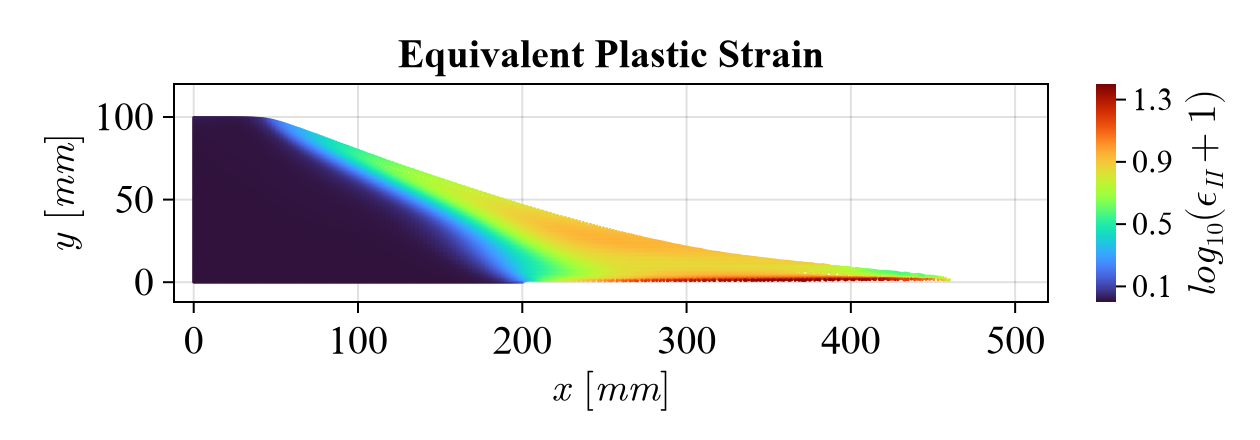

In [12]:
let
    fig = Figure(size=(630, 220), fonts=(; regular=figregular, bold=figbold), fontsize=20)
    ax = Axis(fig[1, 1], xlabel=L"x\ [mm]", ylabel=L"y\ [mm]", aspect=DataAspect(), 
        xticks=(0:0.1:0.5, string.(collect(0:100:500))), 
        yticks=(0:0.05:0.1, string.(collect(0:50:100))), title="Equivalent Plastic Strain")
    cvalue = log10.(mp.epII.+1)
    p1 = scatter!(ax, mp.pos, color=cvalue, colormap=:turbo, marker=:circle, markersize=2,
        label="Particles", colorrange=(0.0, 1.4))
    limits!(ax, -0.012, 0.52, -0.012, 0.12)
    Colorbar(fig[1, 2], p1, label=L"log_{10}(\epsilon_{II}+1)", size=10, vertical=true, 
        spinewidth=0, ticks=0.1:0.4:1.4, ticklabelsize=16)
    display(fig)
    save(joinpath(rtsdir, args.project_name, "epII.png"), fig, px_per_unit=2)
end;

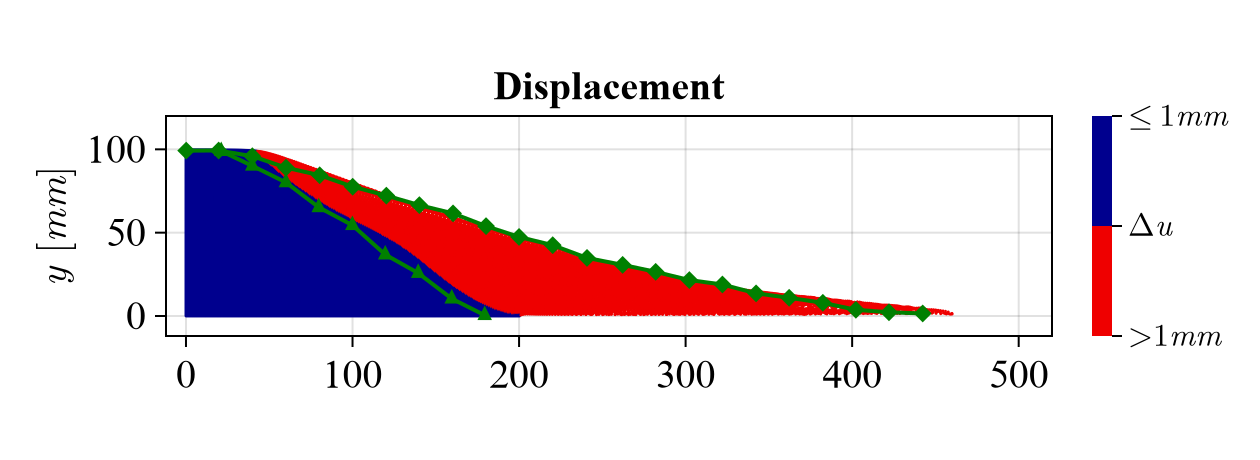

In [13]:
let
    assets  = joinpath(assetsdir, "data")
    failure = readdlm(joinpath(assets, "2d_collapse_experiments/failure.csv"), ',', Float64)
    surface = readdlm(joinpath(assets, "2d_collapse_experiments/surface.csv"), ',', Float64)
    ux = mp.pos[:, 1].-mp.init[:, 1]
    u1 = findall(i->ux[i]>0.001, 1:mp.num)
    u2 = findall(i->ux[i]≤0.001, 1:mp.num)
    ux[u1] .= -1; ux[u2] .= 1
    colors = ["#ef0000", "#00008e"]; cmap = cgrad(colors, 2; categorical = true)
    fig = Figure(size=(630, 230), fonts=(; regular=figregular, bold=figbold), fontsize=20)
    ax = Axis(fig[1, 1], ylabel=L"y\ [mm]", aspect=DataAspect(),
        xticks=(0:0.1:0.5, string.(collect(0:100:500))), title="Displacement",
        yticks=(0:0.05:0.1, string.(collect(0:50:100))))
    p1 = scatter!(ax, mp.pos, color=ux, colormap=cmap, marker=:circle, markersize=2,
        label="Particles")
    scatterlines!(ax, failure[:, 1], failure[:, 2], color=:green, marker=:utriangle,
        markersize=10, strokewidth=0, linewidth=2)
    scatterlines!(ax, surface[:, 1], surface[:, 2], color=:green, marker=:diamond,
        markersize=10, strokewidth=0, linewidth=2)
    limits!(ax, -0.012, 0.52, -0.012, 0.12)
    Colorbar(fig[1, 2], p1, label="\n ", size=10, ticklabelsize=16,
        ticks=(-1:1:1, [L">1mm", L"\Delta u", L"≤1mm"]), vertical=true, spinewidth=0)
    #colsize!(fig.layout, 1, 500)
    rowsize!(fig.layout, 1, 110)
    display(fig)
    save(joinpath(rtsdir, args.project_name, "displacement.png"), fig, px_per_unit=2)
end;

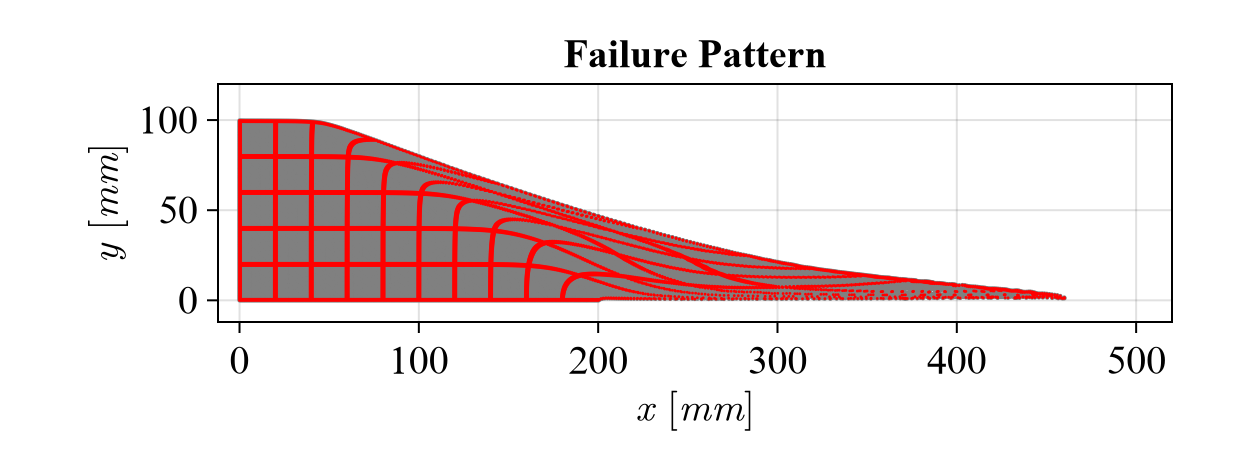

In [14]:
let
    mp_line = Int64[]
    for i in 1:mp.num
        for j in collect(0:0.02:0.98)
            isapprox(mp.init[i, 2], j, atol=mp.space_y/1.9) ? push!(mp_line, i) : nothing
        end
        for k in collect(0:0.02:0.2)
            isapprox(mp.init[i, 1], k, atol=mp.space_x/1.9) ? push!(mp_line, i) : nothing
        end
        unique!(mp_line)
    end
    colors = ["#F9807d", "#00C1C8"]; cmap = cgrad(colors, 2; categorical = true)
    fig = Figure(size=(630, 230), fonts=(; regular=figregular, bold=figbold), fontsize=20)
    ax = Axis(fig[1, 1], xlabel=L"x\ [mm]", ylabel=L"y\ [mm]", aspect=DataAspect(),
        xticks=(0:0.1:0.5, string.(collect(0:100:500))), title="Failure Pattern",
        yticks=(0:0.05:0.1, string.(collect(0:50:100))))
    scatter!(ax, mp.pos, color=:gray, marker=:circle, label="Particles", markersize=3)
    scatter!(ax, mp.pos[mp_line, :], color=:red, marker=:circle, label="Particles", 
        markersize=2)
    limits!(ax, -0.012, 0.52, -0.012, 0.12)
    display(fig)
    save(joinpath(rtsdir, args.project_name, "failure_pattern.png"), fig, px_per_unit=2)
end;